This notebook shows how to forecast stock prices using machine learning and neural networks. In particular I chose GOOGL stock (Alphabet) and I will be using LSTM RNNs to predict future prices.

First download the dataset from the following link:
https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?resource=download&select=GOOGL_2006-01-01_to_2018-01-01.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

%matplotlib notebook

In [2]:
stock_df = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv")
print(stock_df.head())

         Date    Open    High     Low   Close    Volume   Name
0  2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
1  2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2  2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
3  2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
4  2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL


<IPython.core.display.Javascript object>


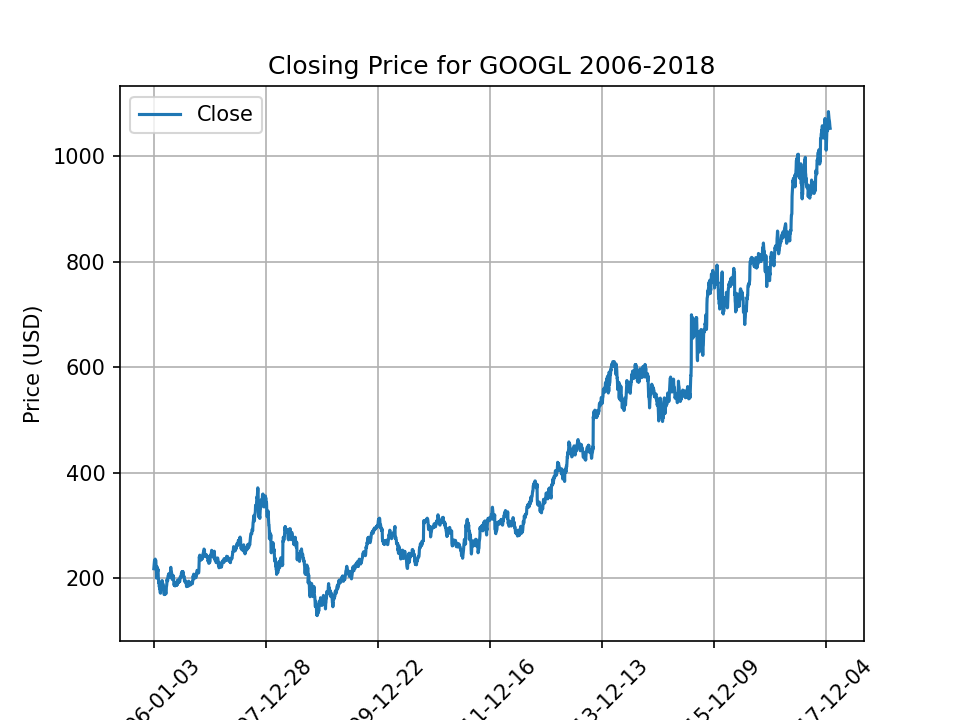

In [3]:
stock_df.plot(x='Date',y='Close',kind='line')
plt.title("Closing Price for GOOGL 2006-2018")
plt.xticks(rotation=45)
plt.ylabel("Price (USD)")
plt.grid()
plt.show()

In [4]:
stock = stock_df[['Close']]
min_val = float(stock.min(axis=0))
max_val = float(stock.max(axis=0))
stock_scaled = 2*((stock-min_val)/(max_val-min_val))-1
print(stock_scaled.head())
print(stock_scaled.tail())

      Close
0 -0.813896
1 -0.803418
2 -0.797122
3 -0.782042
4 -0.780745
         Close
3014  0.966055
3015  0.959759
3016  0.947942
3017  0.939053
3018  0.933720


In [50]:
def split_train_test(dataset,percentage,lookback):
    data_raw = dataset.to_numpy()
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data);
    train_size = int(np.round(percentage*data.shape[0]))
    test_size = data.shape[0]-train_size
    
    x_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:]
    
    x_test = data[train_size:]
    y_test = data[train_size:,-1,:]
    
    return x_train, y_train, x_test, y_test, data

x_train,y_train,x_test,y_test, df = split_train_test(stock_scaled,0.8,20)

In [51]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
df = torch.from_numpy(df).type(torch.Tensor)

In [7]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 1000

In [8]:
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [82]:
model = LSTM(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)
criterion = nn.MSELoss()
lr = 0.01
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

In [83]:
model.train()
loss_curve = []

for epoch in range(num_epochs):
    y_hat = model(x_train)
    loss = criterion(y_hat,y_train)
    loss_curve += [loss.item()]
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    if (epoch % 100 == 0):
        print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

--- Iteration 1: training loss = 0.4621 ---
--- Iteration 101: training loss = 0.0194 ---
--- Iteration 201: training loss = 0.0100 ---
--- Iteration 301: training loss = 0.0068 ---
--- Iteration 401: training loss = 0.0052 ---
--- Iteration 501: training loss = 0.0042 ---
--- Iteration 601: training loss = 0.0036 ---
--- Iteration 701: training loss = 0.0031 ---
--- Iteration 801: training loss = 0.0027 ---
--- Iteration 901: training loss = 0.0025 ---


In [84]:
model.eval()

train_pred_scaled = model(x_train)
train_pred_scaled = train_pred_scaled.data.numpy()
train_pred = 0.5*((train_pred_scaled+1)*(max_val-min_val))+min_val
y_train_orig = 0.5*((y_train.data.numpy()+1)*(max_val-min_val))+min_val

pred_scaled = model(x_test)
pred_scaled = pred_scaled.data.numpy()

pred = 0.5*((pred_scaled+1)*(max_val-min_val))+min_val
y_test_orig = 0.5*((y_test.data.numpy()+1)*(max_val-min_val))+min_val

<IPython.core.display.Javascript object>


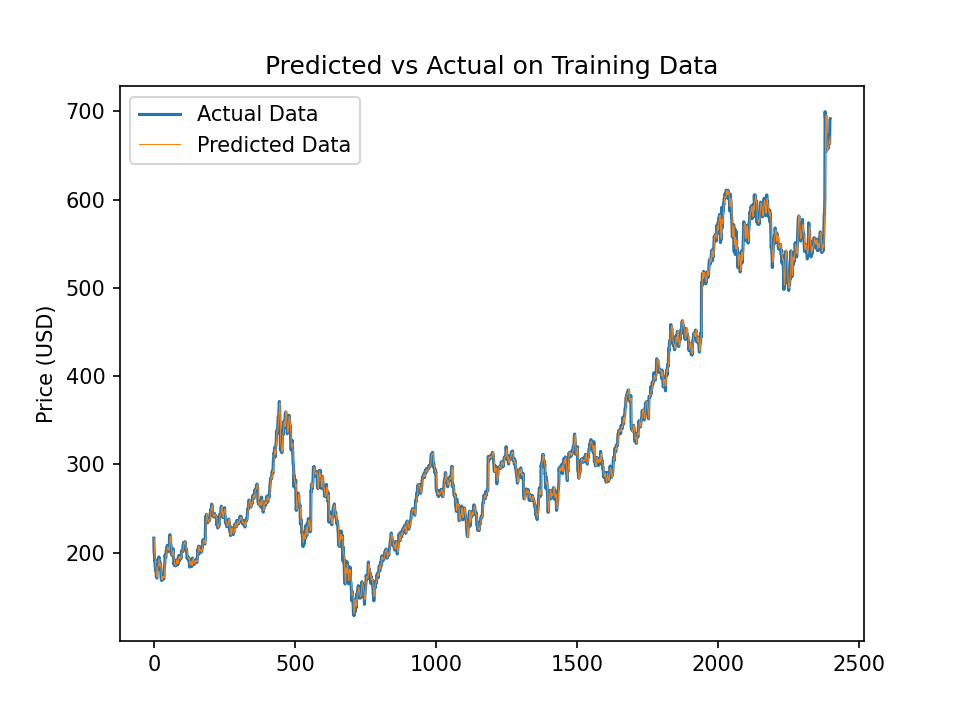

In [85]:
plt.figure()
plt.plot(y_train_orig, label='Actual Data')
plt.plot(train_pred, label='Predicted Data', linewidth=0.5)
plt.title("Predicted vs Actual on Training Data")
plt.ylabel("Price (USD)")
plt.legend()
plt.show() 

<IPython.core.display.Javascript object>


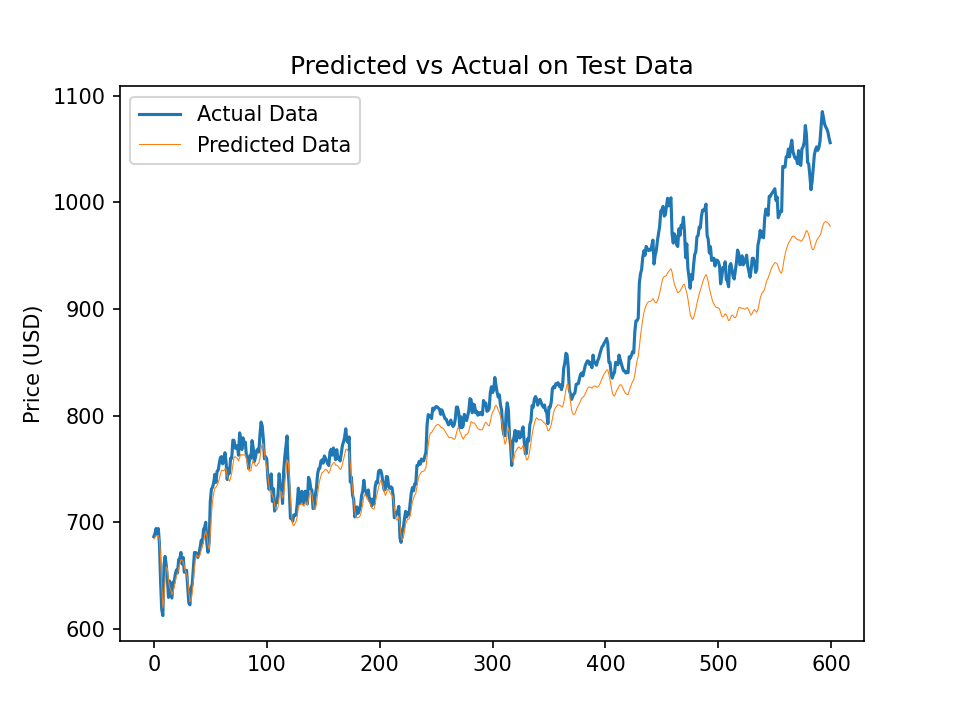

In [86]:
plt.figure()
plt.plot(y_test_orig, label='Actual Data')
plt.plot(pred, label='Predicted Data', linewidth=0.5)
plt.title("Predicted vs Actual on Test Data")
plt.ylabel("Price (USD)")
plt.legend()
plt.show() 

<IPython.core.display.Javascript object>


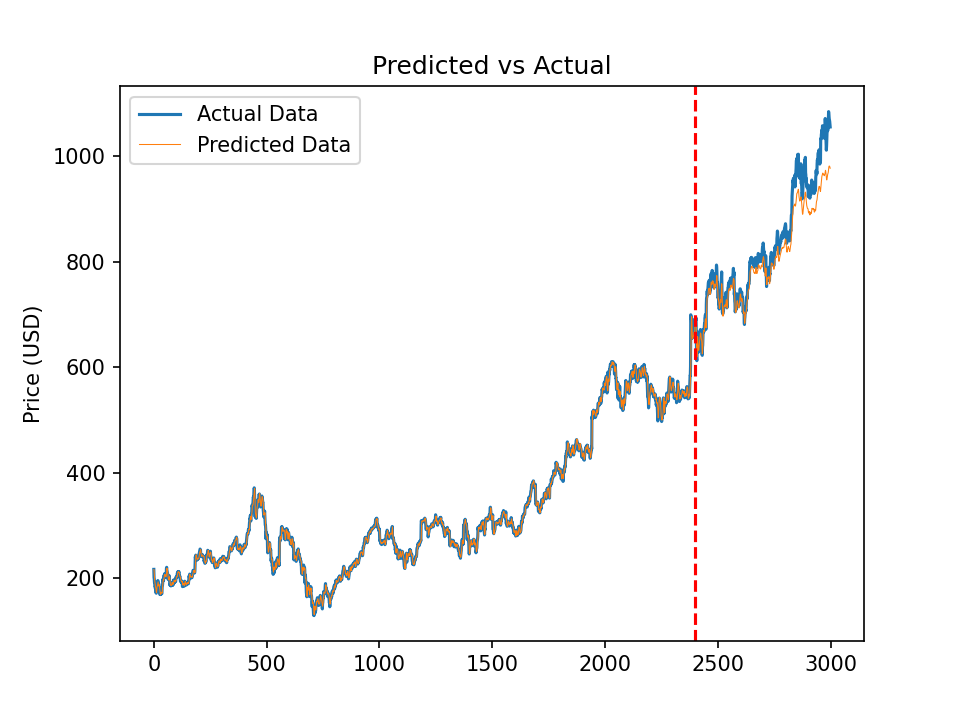

In [91]:
plt.figure()
plt.plot(np.concatenate([y_train_orig,y_test_orig]), label='Actual Data')
plt.plot(np.concatenate([train_pred,pred]), label='Predicted Data', linewidth=0.5)
plt.title("Predicted vs Actual")
plt.ylabel("Price (USD)")
plt.axvline(x=x_train.shape[0],color='red',linestyle='--')
plt.legend()
plt.show() 